<a href="https://colab.research.google.com/github/SarthakGupta345/CollegeDuniClone/blob/main/VisionTranformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
print("Hello wordl")
!pip install nbstripout
!nbstripout your_notebook.ipynb

!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension



Hello wordl
Could not strip 'your_notebook.ipynb': file not found
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /usr/local/lib/python3.12/dist-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    


In [56]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader,Dataset
import random
from torchvision import datasets,transforms
import matplotlib.pyplot as plt


In [ ]:
print(torch.__version__)

2.9.0+cu126


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torchvision.__version__

'0.24.0+cu126'

In [ ]:
print(device)

cuda


In [ ]:
torch.manual_seed(777)
torch.cuda.manual_seed_all(777)
random.seed(42)

In [ ]:
BATCH_SIZE=128
EPOCHS =10
LEARNING_RATE=3e-4
PATH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE =3
CHANNEL =3
EMBEDED_DIM = 256
NUM_HEADS = 8
DEPTH =6
MLP_DIM =512
DROP_RATE=0.1

In [59]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
# ])

transofrm_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2 ,hue =0.2),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [ ]:
train_dataset = datasets.CIFAR10(root='data',train=True,download=True,transform=transform)

In [ ]:
testing_dataset = datasets.CIFAR10(root='data',train=False,download=True,transform=transform)

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
len(train_dataset)

50000

In [ ]:
len(testing_dataset)

10000

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
test_loader = DataLoader(testing_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
train_loader

In [ ]:
len(train_loader)

391

In [ ]:
print(train_loader)

In [ ]:

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size

        # Patch projection using Conv2d
        self.proj = nn.Conv2d(
            in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        num_patches = (img_size // patch_size) ** 2

        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, 1 + num_patches, embed_dim)
        )

    def forward(self, x: torch.Tensor):
        B = x.size(0)               # Batch size

        x = self.proj(x)           # Shape -> (B, embed_dim, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # -> (B, num_patches, embed_dim)

        cls_token = self.cls_token.expand(B, -1, -1) # -> (B, 1, embed_dim)

        x = torch.cat((cls_token, x), dim=1)  # Add class token

        x = x + self.pos_embedding  # Add positional embedding
        return x

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate=0.1):
        super().__init__()

        # LayerNorm before Attention (Pre-LN)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)

        # LayerNorm before MLP
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        # Self-Attention with skip connection
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out

        # Feed Forward with skip connection
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate=0.1):
        super().__init__()

        # Patch + Position embedding
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Transformer Encoder Stack
        self.encoder = nn.Sequential(
            *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)]
        )

        # Final normalization before classification
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head (applied only to CLS token)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)   # (B, N+1, E)
        x = self.encoder(x)           # (B, N+1, E)
        x = self.norm(x)              # (B, N+1, E)
        cls_token = x[:, 0]           # (B, E)
        return self.head(cls_token)   # (B, num_classes)

In [ ]:
#model instanciation

model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATH_SIZE,
    in_channels=CHANNEL,
    num_classes=NUM_CLASSES,
    embed_dim=EMBEDED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
).to(device)

In [ ]:
model

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp):

In [ ]:
#Loss function

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=LEARNING_RATE
)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [ ]:
#training Loop

def train(model,loader,optimizer,criterion):
  model.train()

  total_loss,correct = 0,0
  for x, y in loader:
    x,y = x.to(device),y.to(device)

    optimizer.zero_grad()

    output = model(x)
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()*x.size(0)
    correct += (output.argmax(1) == y).type(torch.float).sum().item()
  return total_loss/len(loader.dataset),correct/len(loader.dataset)


In [ ]:
def evaluate(model,loader):
  model.eval()
  correct = 0
  with torch.inference_mode():
    for x,y in loader:
      x,y = x.to(device),y.to(device)
      output = model(x)
      correct += (output.argmax(1) == y).type(torch.float).sum().item()
  return correct/len(loader.dataset)


In [ ]:
from tqdm.auto import tqdm

In [46]:
train_accuracies,test_accuracies = [],[]

for epoch in tqdm(range(EPOCHS)):
  train_loss,train_acc = train(model,train_loader,optimizer,criterion)
  test_acc = evaluate(model,test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch {epoch+1}/{EPOCHS},Train loss :{train_loss:.4f},train acc:{train_acc:.4f},test acc:{test_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10,Train loss :0.9504,train acc:0.6587,test acc:0.5906
Epoch 2/10,Train loss :0.9070,train acc:0.6715,test acc:0.5931
Epoch 3/10,Train loss :0.8582,train acc:0.6920,test acc:0.5990
Epoch 4/10,Train loss :0.8085,train acc:0.7080,test acc:0.6015
Epoch 5/10,Train loss :0.7545,train acc:0.7263,test acc:0.6121
Epoch 6/10,Train loss :0.6998,train acc:0.7478,test acc:0.6022
Epoch 7/10,Train loss :0.6570,train acc:0.7606,test acc:0.6078
Epoch 8/10,Train loss :0.6044,train acc:0.7823,test acc:0.6002
Epoch 9/10,Train loss :0.5504,train acc:0.8009,test acc:0.6001
Epoch 10/10,Train loss :0.5088,train acc:0.8163,test acc:0.5904


In [48]:
train_accuracies

[0.65866,
 0.67154,
 0.69198,
 0.70804,
 0.72628,
 0.74778,
 0.76062,
 0.78232,
 0.80094,
 0.81632]

In [49]:
test_accuracies

[0.5906, 0.5931, 0.599, 0.6015, 0.6121, 0.6022, 0.6078, 0.6002, 0.6001, 0.5904]

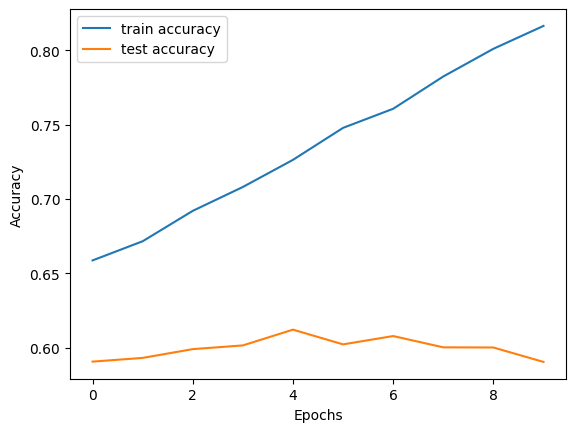

In [51]:
plt.plot(train_accuracies,label='train accuracy')
plt.plot(test_accuracies,label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
def predict_and_plot_grid(model, dataset, classes, grid_size=3, device='cuda'):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))

    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                idx = random.randint(0, len(dataset) - 1)
                img, true_label = dataset[idx]

                input_tensor = img.unsqueeze(0).to(device)

                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)

                img_display = img / 2 + 0.5  # Un-normalize if normalized
                npimg = img_display.cpu().numpy()

                axes[i][j].imshow(np.transpose(npimg, (1, 2, 0)))

                pred_label = predicted.item()
                title_color = 'g' if pred_label == true_label else 'r'

                axes[i][j].set_title(
                    f"True: {classes[true_label]}\nPred: {classes[pred_label]}",
                    color=title_color,
                    fontsize=10
                )
                axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

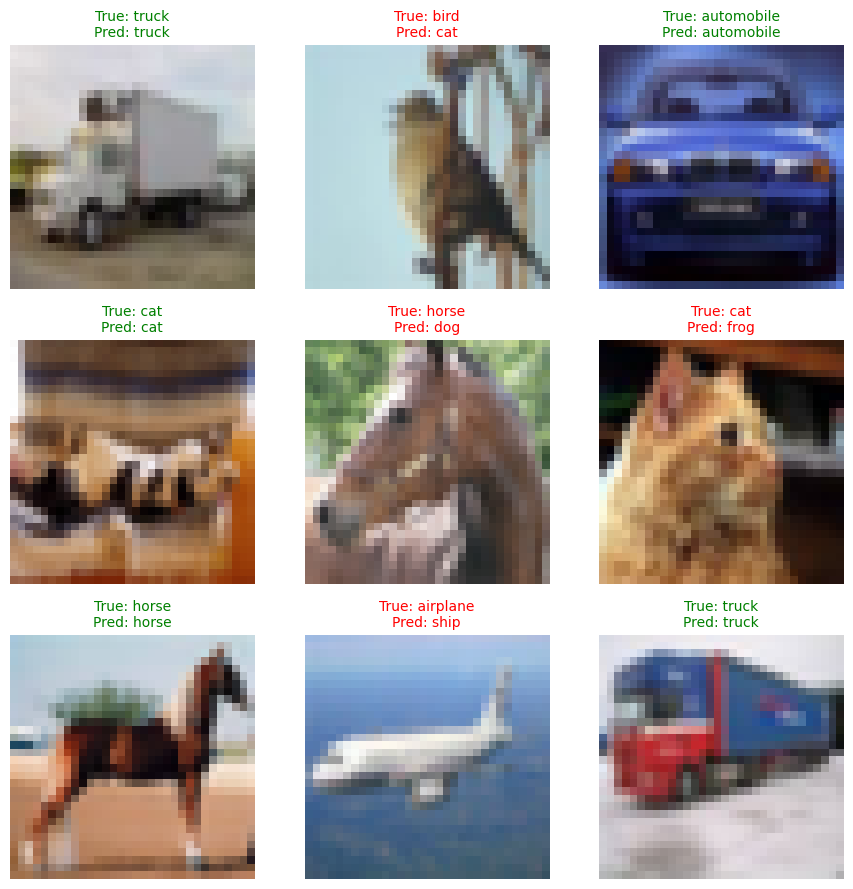

In [53]:
predict_and_plot_grid(model,testing_dataset,classes=train_dataset.classes, grid_size=3)